In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess



import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 102.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 96.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 99.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [7]:
# Load & squeeze
hist_suit = rxr.open_rasterio("hist_suit.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not hist_suit.rio.crs:
    hist_suit = hist_suit.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(hist_suit)
sand = sand.rio.reproject_match(hist_suit)
ph   = ph.rio.reproject_match(hist_suit)
elev = elev.rio.reproject_match(hist_suit)

# Ensure binary and combine
combined_hist = (hist_suit * clay * sand * ph * elev).astype("uint8")

# Save to GeoTIFF
combined_hist.name = "juniper_combined_suitability_hist"
combined_hist.rio.to_raster("juniper_suitability_combined_hist.tif")

print("Combined suitability saved as juniper_suitability_combined_hist.tif")

Combined suitability saved as juniper_suitability_combined_hist.tif


In [11]:
# Load & squeeze
fut_suit = rxr.open_rasterio("fut_suit.tif").squeeze()
clay   = rxr.open_rasterio("clay_suitability.tif").squeeze()
sand   = rxr.open_rasterio("sand_suitability.tif").squeeze()
ph     = rxr.open_rasterio("ph_suitability.tif").squeeze()
elev   = rxr.open_rasterio("elev_suitability.tif").squeeze()

if not fut_suit.rio.crs:
    fut_suit = fut_suit.rio.write_crs("EPSG:4326")
    
#  Reproject to match precip
clay = clay.rio.reproject_match(fut_suit)
sand = sand.rio.reproject_match(fut_suit)
ph   = ph.rio.reproject_match(fut_suit)
elev = elev.rio.reproject_match(fut_suit)

# Ensure binary and combine
combined_future = (fut_suit *clay * sand * ph *elev).astype("uint8")

# Save to GeoTIFF
combined_future.name = "juniper_combined_suitability_future"
combined_future.rio.to_raster("juniper_suitability_combined_future.tif")

print("Combined suitability saved as juniper_suitability_combined_future.tif")

Combined suitability saved as juniper_suitability_combined_future.tif


In [8]:
if juniper_occur_gdf.crs != combined_hist.rio.crs:
    juniper_occur_gdf = juniper_occur_gdf.to_crs(combined_hist.rio.crs)

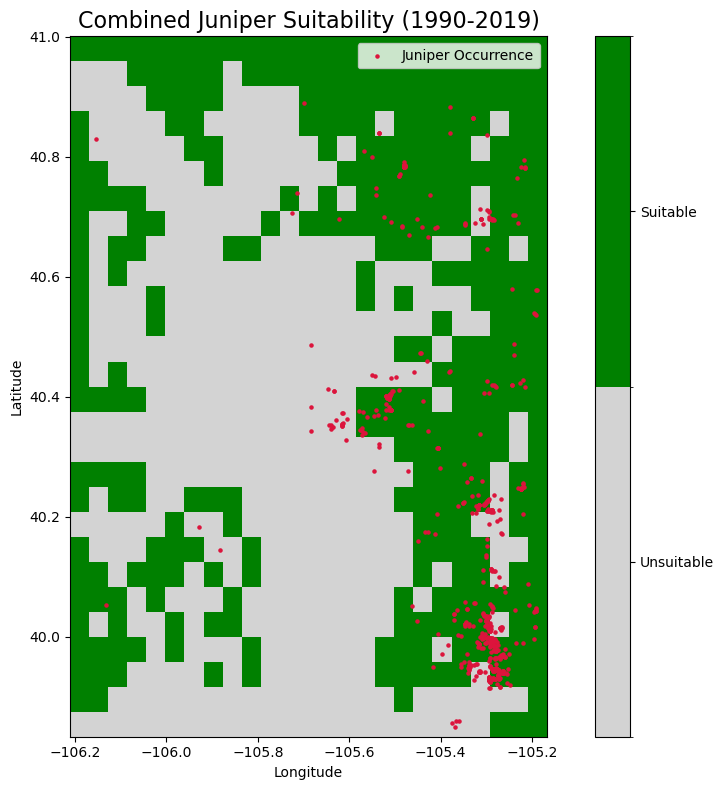

In [9]:
# Load combined suitability raster
combined_hist = rxr.open_rasterio("juniper_suitability_combined_hist.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_hist.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (1990-2019)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [12]:
if juniper_occur_gdf.crs != combined_future.rio.crs:
    juniper_occur_gdf = juniper_occur_gdf.to_crs(combined_future.rio.crs)

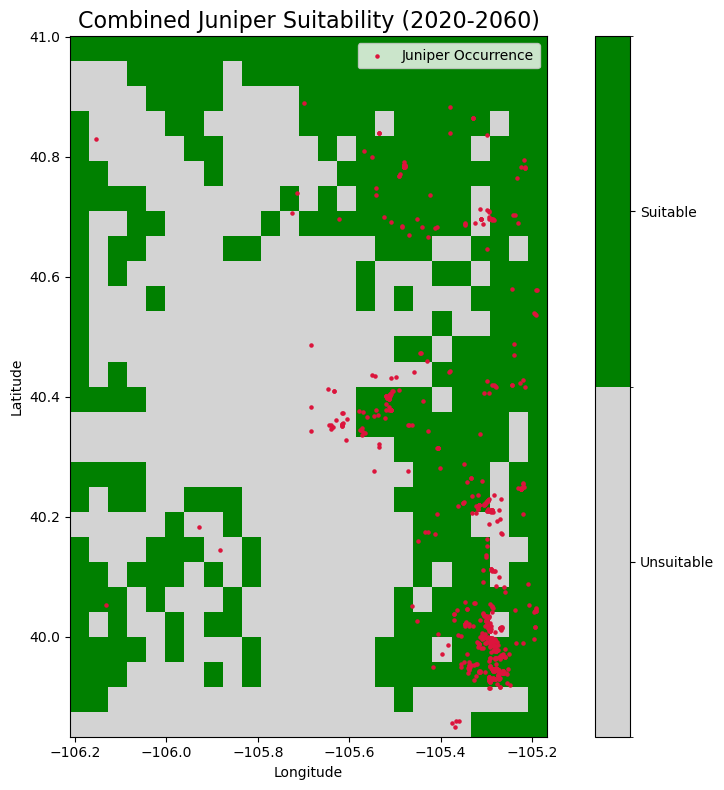

In [13]:
# Load combined suitability raster
combined_future = rxr.open_rasterio("juniper_suitability_combined_future.tif").squeeze()

# Define binary colormap (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot 
fig, ax = plt.subplots(figsize=(10, 8))
im = combined_future.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# add occurrence points
juniper_occur_gdf.plot(ax=ax, color='crimson', markersize=5, label='Juniper Occurrence')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Labels and formatting
ax.set_title("Combined Juniper Suitability (2020-2060)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(os.getcwd())
print(os.listdir())

In [ ]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip")

# Load CSV (DataFrame)
csv_path = "~/data-store/CAST_Species_Test/Colorado_future_fires.csv"
csv_df = pd.read_csv(csv_path)

In [ ]:
shapefile_gdf = gpd.read_file("zip://level3_ecoregion.zip!us_eco_l3_state_boundaries.shp")

In [ ]:
print("Shapefile columns:\n", shapefile_gdf.columns)
print(shapefile_gdf.head())

print("\nCSV columns:\n", csv_df.columns)
print(csv_df.head())

In [ ]:
shapefile_gdf['US_L3CODE'] = shapefile_gdf['US_L3CODE'].astype(int)

In [ ]:
shapefile_gdf.info()
csv_df.info()

In [ ]:
joined_gdf = shapefile_gdf[['US_L3CODE','geometry']].merge(csv_df[['US_L3CODE', 'year', 'En_NFire', 'En_BurnArea']], on=['US_L3CODE'], how='inner')

In [ ]:
joined_gdf

In [ ]:
df = pd.read_csv('Colorado_future_fires.csv', dtype={'year': int})

In [ ]:
joined_gdf.plot(
    column='En_NFire', 
    cmap='OrRd', 
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion")
plt.axis('off')
plt.show()

In [ ]:
forest_gdf = forest_gdf.to_crs(joined_gdf.crs)

In [ ]:
roosevelt_clip = gpd.clip(joined_gdf, forest_gdf)

In [ ]:
roosevelt_clip.plot(
    column='En_NFire',
    cmap='OrRd',
    legend=True,
    figsize=(12, 8),
    edgecolor='black'
)
plt.title("Avg. Number of Fires by Ecoregion in Roosevelt National Forest")
plt.axis('off')
plt.show()

In [ ]:
print(joined_gdf[['US_L3CODE','geometry', 'year', 'En_NFire', 'En_BurnArea']].dropna().head())

In [ ]:
print(joined_gdf.columns)

In [ ]:
# Path to the zip file
zip_path = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist.zip")

extract_to = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted")

os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted all files to: {extract_to}")

In [ ]:
extract_dir = os.path.expanduser("~/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted")

# Walk through the directory and print all files
for root, dirs, files in os.walk(extract_dir):
    print(f"\nDirectory: {root}")
    for file in files:
        print(f"  - {file}")

In [ ]:
gdf = gdf.to_crs(forest_gdf.crs)
juniper_occur_gdf = juniper_occur_gdf.to_crs(forest_gdf.crs)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot forest boundary
forest_gdf.plot(ax=ax, color='none', edgecolor='green', linewidth=2, label='Forest Boundary')

# Plot historical fire polygons
gdf.plot(ax=ax, color='orangered', alpha=0.6, edgecolor='black', linewidth=0.2, label='Fire Events')

# Plot Juniper occurrences
juniper_occur_gdf.plot(ax=ax, color='blue', markersize=10, label='Juniper Occurrences')


ax.set_title("Fire History, Forest Boundary, and Juniper Occurrences")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
minx, miny, maxx, maxy = forest_gdf.total_bounds

fig, ax = plt.subplots(figsize=(12, 10))


forest_gdf.plot(ax=ax, color='none', edgecolor='green', linewidth=2, label='Forest Boundary')


gdf.plot(ax=ax, color='orangered', alpha=0.6, edgecolor='black', linewidth=0.2, label='Fire Events')


juniper_occur_gdf.plot(ax=ax, color='blue', markersize=10, label='Juniper Occurrences')


ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Clean up the plot
ax.set_title("Fire History")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
fire_gdf = gpd.read_file('/home/jovyan/data-store/data/iplant/home'
'/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted/fired_uscan_to2021121_events.shp')

In [ ]:
print(fire_gdf.columns)

In [ ]:
fire_path = '/home/jovyan/data-store/data/iplant/home/elemilene01/data_download_habitat_suitability/firedpy_hist_extracted/fired_uscan_to2021121_events.shp'
fire_gdf = gpd.read_file(fire_path)

In [ ]:
from shapely.geometry import box
import numpy as np

minx, miny, maxx, maxy = forest_gdf.total_bounds

# Define cell size
cell_size = 1000  

# Create grid
cols = np.arange(minx, maxx, cell_size)
rows = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x + cell_size, y + cell_size) for x in cols for y in rows]

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=forest_gdf.crs)

# Clip to forest area
grid = gpd.overlay(grid, forest_gdf, how='intersection')

In [ ]:
fire_gdf = fire_gdf.to_crs(grid.crs)


joined = gpd.sjoin(fire_gdf[['ig_year', 'geometry']], grid, how="inner", predicate="intersects")

# Count number of unique fire years per cell
fire_years_per_cell = joined.groupby('index_right')['ig_year'].nunique()

# Attach back to grid
grid['n_fire_years'] = grid.index.map(fire_years_per_cell).fillna(0)

In [ ]:
# Define time range 
year_range = fire_gdf['ig_year'].max() - fire_gdf['ig_year'].min() + 1

# Compute metrics
grid['return_period'] = year_range / grid['n_fire_years'].replace(0, np.nan)
grid['fire_probability'] = 1 / grid['return_period']

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(column='fire_probability', cmap='Reds', legend=True, ax=ax, edgecolor='black')

cbar = grid_plot.get_figure().get_axes()[1]
cbar.set_ylabel('Annual Fire Probability', fontsize=12)

forest_gdf.boundary.plot(ax=ax, color='green', linewidth=1)
ax.set_title("Fire Probability Map")
plt.tight_layout()
plt.show()

In [ ]:
#return period for fire data for each year
#pixel for each year
#probability